In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
import scipy.stats as stats
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

In [2]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#TODO: verschillende activiteiten in 1 frame
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
       
        # Retrieve the most often used label in this segment
        label = stats.mode(df['activity'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

   #print("ORG:",frames)
    # Bring the segments into a better shape
    frames = np.asarray(frames)#.reshape(-1, frame_size, N_FEATURES)
    print("NEW:",frames)
    labels = np.asarray(labels)

    return frames, labels

def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += (size / 2)
        
def segment_signal(data,window_size, overlap):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["time"], window_size):
        start = int(start)
        end = int(end)
        x = data["x"][start:end]
        y = data["y"][start:end]
        z = data["z"][start:end]
        if(len(data["time"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [3]:
column_names_org = ['time', 'x', 'y', 'z']
moves = ["jump_fast", "jump_slow", "side_swing", "cross_over", "forward_180", "backward_180", "mistakes"]
freq = {}

freq["jump_fast"] = 55.55724863047715
freq["jump_slow"] = 51.69966253926424
freq["side_swing"] = 49.317387522335395
freq["cross_over"] = 51.93077692731317
freq["forward_180"] = 52.602864583333336
freq["backward_180"] = 53.0625

In [4]:
f = 0
for fq in freq.values():
    f += fq
f = f/len(freq)
f

52.361740033787214

## labeling

In [9]:
#label activity
le = preprocessing.LabelEncoder()
le.fit(moves)
label = le.inverse_transform([0,1,2,3,4, 5,6])
label

array(['backward_180', 'cross_over', 'forward_180', 'jump_fast',
       'jump_slow', 'mistake', 'side_swing'], dtype=object)

# preprocessing

# <font color='green' >PROEFPERSOON 1

## backward 180

In [253]:
forward_180_left_backwards_1 = []
forward_180_left_backwards_1_labels = []

forward_180_right_backwards_1= []
forward_180_right_backwards_1_labels= []

forward_180_left_backwards_other_side_1 = []
forward_180_left_backwards_other_side_1_labels = []

forward_180_right_backwards_other_side_1= []
forward_180_right_backwards_other_side_1_labels= []

#### backward_180_left

In [254]:
#8 SEGMENTEN
forward_180_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)

In [256]:
f1 =  forward_180_left_backwards1[forward_180_left_backwards1["time"] <= 31979000000000]
f2 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31979000000000) & (forward_180_left_backwards1["time"] <= 31983000000000)]
f3 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31983000000000) & (forward_180_left_backwards1["time"] <= 31987500000000)]
f4 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31987500000000) & (forward_180_left_backwards1["time"] <= 31991800000000)]
f5 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31991800000000) & (forward_180_left_backwards1["time"] <= 31995800000000)]
f6 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31995800000000) & (forward_180_left_backwards1["time"] <= 31999900000000)]
f7 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31999900000000) & (forward_180_left_backwards1["time"] <= 32004400000000)]
f8 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 32004400000000) & (forward_180_left_backwards1["time"] <= 32009000000000)]

In [257]:
f1 = preprocess(f1, "backward_180", 1.2, 0.8)
f2 = preprocess(f2, "backward_180", 0.9, 0.5)
f3 = preprocess(f3, "backward_180", 1, 1)
f4 = preprocess(f4, "backward_180", 0.8, 0.9)
f5 = preprocess(f5, "backward_180", 0.8, 0.9)
f6 = preprocess(f6, "backward_180", 0.8, 0.8)
f7 = preprocess(f7, "backward_180", 1.1, 0.9)
f8 = preprocess(f8, "backward_180", 1.1, 0.9)

In [259]:
forward_180_left_backwards_1 = [f1,f2, f3, f4, f5, f6, f7, f8]

#### backward_180_right

In [261]:
#EERSTE EN LAATSTE STUKJES NIET GEKNIPT
#5 SEGMENTEN
forward_180_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)

#3 SEGMENTEN
forward_180_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)

forward_180_right_backwards4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim4.csv", sep=';', header=0, skipinitialspace=True)

forward_180_right_backwards5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim5.csv", sep=';', header=0, skipinitialspace=True)
forward_180_right_backwards6 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim6.csv", sep=';', header=0, skipinitialspace=True)


In [263]:
f2 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11918100000000) & (forward_180_right_backwards1["time"] <= 11923700000000)]
f3 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11923700000000) & (forward_180_right_backwards1["time"] <= 11929200000000)]
f4 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11929200000000) & (forward_180_right_backwards1["time"] <= 11935500000000)]
f5 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11935500000000) & (forward_180_right_backwards1["time"] <= 11941400000000)]

f6 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] <= 11951900000000)]
f7 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11951900000000) & (forward_180_right_backwards2["time"] <= 11956800000000)]
f8 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11956800000000) & (forward_180_right_backwards2["time"] <= 11961900000000)]

f9 =  forward_180_right_backwards4[(forward_180_right_backwards4["time"] >= 11976300000000)]
f10 = forward_180_right_backwards4[(forward_180_right_backwards4["time"] <= 11976300000000)]

In [264]:
f2 = preprocess(f2, "backward_180", 1.7, 0.9)
f3 = preprocess(f3, "backward_180", 1, 1.2)
f4 = preprocess(f4, "backward_180", 1.5, 1.7)
f5 = preprocess(f5, "backward_180", 2, 1)
f6 = preprocess(f6, "backward_180", 1, 1)
f7 = preprocess(f7, "backward_180", 1.5, 1.5)
f8 = preprocess(f8, "backward_180", 1.7, 1.5)
f9 = preprocess(f9, "backward_180", 1.5, 0.6)

In [265]:
forward_180_right_backwards_1 = [f2, f3, f4, f5, f6, f7, f8, f9]

#### forward_180_left_backwards_other_side

In [267]:
#8 segmenten
forward_180_left_backwards_other1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_backwards_tim_other_side1.csv", sep=';', header=0, skipinitialspace=True)

In [269]:
f1 =  forward_180_left_backwards_other1[forward_180_left_backwards_other1["time"] <= 32379000000000]
f2 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32379000000000) & (forward_180_left_backwards_other1["time"] <= 32383100000000)]
f3 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32383100000000) & (forward_180_left_backwards_other1["time"] <= 32387300000000)]
f4 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32387300000000) & (forward_180_left_backwards_other1["time"] <= 32391400000000)]
f5 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32391400000000) & (forward_180_left_backwards_other1["time"] <= 32395500000000)]
f6 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32395500000000) & (forward_180_left_backwards_other1["time"] <= 32399600000000)]
f7 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32399600000000) & (forward_180_left_backwards_other1["time"] <= 32403800000000)]
f8 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32403800000000) & (forward_180_left_backwards_other1["time"] <= 32408100000000)]


In [270]:
f1 = preprocess(f1, "backward_180", 0.8, 0.6)
f2 = preprocess(f2, "backward_180", 1, 0.7)
f3 = preprocess(f3, "backward_180", 1.3, 0.6)
f4 = preprocess(f4, "backward_180", 1.2, 0.6)
f5 = preprocess(f5, "backward_180", 1.1, 0.7)
f6 = preprocess(f6, "backward_180", 1.3, 0.6)
f7 = preprocess(f7, "backward_180", 1.2, 0.7)
f8 = preprocess(f8, "backward_180", 1.2, 0.7)

In [272]:
forward_180_left_backwards_other_side_1 = [f1,f2, f3, f4, f5, f6, f7, f8]

#### forward_180_right_backwards_other_side

In [274]:
#7 SEGMENTEN
forward_180_right_backwards_other1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_other_side_tim1.csv", sep=';', header=0, skipinitialspace=True)
#1 SEGMENT
forward_180_right_backwards_other2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_other_side_tim2.csv", sep=';', header=0, skipinitialspace=True)


In [276]:
f1 =  forward_180_right_backwards_other1[forward_180_right_backwards_other1["time"] <= 31867200000000]
f2 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31867200000000) & (forward_180_right_backwards_other1["time"] <= 31871500000000)]
f3 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31871500000000) & (forward_180_right_backwards_other1["time"] <= 31875700000000)]
f4 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31875700000000) & (forward_180_right_backwards_other1["time"] <= 31880400000000)]
f5 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31880400000000) & (forward_180_right_backwards_other1["time"] <= 31885400000000)]
f6 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31885400000000) & (forward_180_right_backwards_other1["time"] <= 31889600000000)]
f7 =  forward_180_right_backwards_other1[forward_180_right_backwards_other1["time"] >= 31889600000000]

f8 =  forward_180_right_backwards_other2[forward_180_right_backwards_other2["time"] <= 31918500000000]

In [277]:
f1 = preprocess(f1, "backward_180", 1.8, 0.4)
f2 = preprocess(f2, "backward_180", 1.2, 0.4)
f3 = preprocess(f3, "backward_180", 1.2, 0.6)
f4 = preprocess(f4, "backward_180", 1.2, 0.6)
f5 = preprocess(f5, "backward_180", 2, 0.6)
f6 = preprocess(f6, "backward_180", 1.2, 0.6)
f7 = preprocess(f7, "backward_180", 1.2, 4.8)
f8 = preprocess(f8, "backward_180", 1.5, 0.5)

In [279]:
forward_180_right_backwards_other_side_1 = [f1,f2, f3, f4, f5, f6, f7, f8]

### SEGMENTATION

In [281]:
segments_backward_180 = []
labels_backward_180 =  []

    for i in range(0, len(forward_180_left_backwards_1)):
        segments, labels = segment_signal(forward_180_left_backwards_1[i], int(f), False)
        segments_backward_180.append(segments)
        labels_backward_180.append(labels)

    for i in range(0, len(forward_180_right_backwards_1)):
        forward_180_right_backwards_1[i] =  feature_extraction_segmentation(forward_180_right_backwards_1[i],1, True)

    for i in range(0, len(forward_180_left_backwards_other_side_1)):
        forward_180_left_backwards_other_side_1[i] =  feature_extraction_segmentation(forward_180_left_backwards_other_side_1[i],1, True)
    
    for i in range(0, len(forward_180_right_backwards_other_side_1)):
        forward_180_right_backwards_other_side_1[i] =  feature_extraction_segmentation(forward_180_right_backwards_other_side_1[i],1, True)

In [ ]:
segments_list = []
labels_list =  []
for m in merged.activity.unique():
    segments, labels = segment_signal(merged[merged["activity"] == m], int(f), False)
    segments_list.append(segments)
    labels_list.append(labels)
segments = np.concatenate(segments_list)
labels = np.concatenate(labels_list)

print(labels.shape)
print(segments.shape)

In [287]:
forward_180_left_backwards_1 = shuffle(forward_180_left_backwards_1).head(shape).copy()
forward_180_right_backwards_1 = shuffle(forward_180_right_backwards_1).head(shape).copy()
forward_180_left_backwards_other_side_1 = shuffle(forward_180_left_backwards_other_side_1).head(shape).copy()
forward_180_right_backwards_other_side_1 = shuffle(forward_180_right_backwards_other_side_1).head(shape).copy()

In [288]:
backward_180_1 = pd.concat([forward_180_left_backwards_1, forward_180_right_backwards_1, forward_180_left_backwards_other_side_1, forward_180_right_backwards_other_side_1])

# <font color='green' >PROEFPERSOON 2

## backward 180

In [289]:
forward_180_left_other_side_2 = []
forward_180_right_other_side_2  = []
forward_180_left_backwards_2 = []
forward_180_right_backwards_2 = []

#### forward_180_left_backwards

In [290]:
#7 SEGMENTEN
forward_180_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_backwards1.csv", sep=';', header=0, skipinitialspace=True)

#1 SEGMENT
forward_180_left_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_backwards2.csv", sep=';', header=0, skipinitialspace=True)
forward_180_left_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_backwards3.csv", sep=';', header=0, skipinitialspace=True)

In [292]:
f1 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] <= 11248600000000)]
f2 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11248600000000) & (forward_180_left_backwards1["time"] <= 11253300000000)]
f3 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11253300000000) & (forward_180_left_backwards1["time"] <= 11258300000000)]
f4 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11258300000000) & (forward_180_left_backwards1["time"] <= 11263400000000)]
f5 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11263400000000) & (forward_180_left_backwards1["time"] <= 11268300000000)]
f6 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11268300000000) & (forward_180_left_backwards1["time"] <= 11273000000000)]
f7 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11273000000000)]

f8 =  forward_180_left_backwards2[(forward_180_left_backwards2["time"] <= 11287300000000)]

In [293]:
f1 = preprocess(f1, "backward_180", 1, 0.7)
f2 = preprocess(f2, "backward_180", 1, 1)
f3 = preprocess(f3, "backward_180", 1.3, 0.9)
f4 = preprocess(f4, "backward_180", 1.4, 0.9)
f5 = preprocess(f5, "backward_180", 1.2, 1)
f6 = preprocess(f6, "backward_180", 1.1, 1)
f7 = preprocess(f7, "backward_180", 1.2, 2.4)
f8 = preprocess(f8, "backward_180", 2, 1.1)

In [295]:
forward_180_left_backwards_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### forward_180_right_backwards

In [297]:
#4SEGMENTEN
forward_180_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)
#4 SEGMENTEN
forward_180_right_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_backwards3.csv", sep=';', header=0, skipinitialspace=True)

In [299]:
f1 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] <= 11719400000000)]
f2 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11719400000000) & (forward_180_right_backwards2["time"] <= 11723600000000)]
f3 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11723600000000) & (forward_180_right_backwards2["time"] <= 11727900000000)]
f4 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11727900000000) ]

f5 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11736100000000) & (forward_180_right_backwards3["time"] <= 11740600000000)]
f6 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11740600000000) & (forward_180_right_backwards3["time"] <= 11744900000000)]
f7 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11744900000000) & (forward_180_right_backwards3["time"] <= 11749400000000)]
f8 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11749400000000) & (forward_180_right_backwards3["time"] <= 11754200000000)]

In [300]:
f1 = preprocess(f1, "backward_180", 0.2, 0.7)
f2 = preprocess(f2, "backward_180", 0.7, 1)
f3 = preprocess(f3, "backward_180", 0.7, 1)
f4 = preprocess(f4, "backward_180", 0.8, 1.3)
f5 = preprocess(f5, "backward_180", 1, 1.1)
f6 = preprocess(f6, "backward_180", 0.9, 0.8)
f7 = preprocess(f7, "backward_180", 0.8, 1.1)
f8 = preprocess(f8, "backward_180", 1.3, 1)

In [302]:
forward_180_right_backwards_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### forward_180_left_other_side

In [304]:
#8 SEGMENTEN
forward_180_left_otherside1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_back_otherside1.csv", sep=';', header=0, skipinitialspace=True)

In [306]:
f1 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] <= 20761300000000)]
f2 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20761300000000) & (forward_180_left_otherside1["time"] <= 20766800000000)]
f3 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20766800000000) & (forward_180_left_otherside1["time"] <= 20772100000000)]
f4 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20772100000000) & (forward_180_left_otherside1["time"] <= 20777400000000)]
f5 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20777400000000) & (forward_180_left_otherside1["time"] <= 20782700000000)]
f6 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20782700000000) & (forward_180_left_otherside1["time"] <= 20787800000000)]
f7 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20787800000000) & (forward_180_left_otherside1["time"] <= 20793100000000)]
f8 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20793100000000) & (forward_180_left_otherside1["time"] <= 20798900000000)]

In [307]:
f1 = preprocess(f1, "backward_180", 1.7, 1.1)
f2 = preprocess(f2, "backward_180", 1.6, 1.7)
f3 = preprocess(f3, "backward_180", 1.7, 1.1)
f4 = preprocess(f4, "backward_180", 1.7, 1.1)
f5 = preprocess(f5, "backward_180", 1.8, 1.2)
f6 = preprocess(f6, "backward_180", 1.5, 1.3)
f7 = preprocess(f7, "backward_180", 1.5, 1.3)
f8 = preprocess(f8, "backward_180", 1.8, 1.5)

In [309]:
forward_180_left_other_side_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### forward_180_right_other_side

In [311]:
forward_180_right_otherside1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_backwards_otherside.csv", sep=';', header=0, skipinitialspace=True)

In [313]:
f1 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] <= 21087100000000)]
f2 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21087100000000) & (forward_180_right_otherside1["time"] <= 21091500000000)]
f3 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21091500000000) & (forward_180_right_otherside1["time"] <= 21095700000000)]
f4 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21095700000000) & (forward_180_right_otherside1["time"] <= 21100000000000)]
f5 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21100000000000) & (forward_180_right_otherside1["time"] <= 21104500000000)]
f6 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21104500000000) & (forward_180_right_otherside1["time"] <= 21109700000000)]
f7 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21109700000000) & (forward_180_right_otherside1["time"] <= 21115000000000)]
f8 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21115000000000) & (forward_180_right_otherside1["time"] <= 21119800000000)]

In [314]:
f1 = preprocess(f1, "backward_180", 1.3, 0.5)
f2 = preprocess(f2, "backward_180", 1, 0.7)
f3 = preprocess(f3, "backward_180", 0.8, 0.7)
f4 = preprocess(f4, "backward_180", 0.9, 0.7)
f5 = preprocess(f5, "backward_180", 1, 0.7)
f6 = preprocess(f6, "backward_180", 0.9, 1.6)
f7 = preprocess(f7, "backward_180", 1.7, 0.8)
f8 = preprocess(f8, "backward_180", 1, 0.8)

In [316]:
forward_180_right_other_side_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

### SEGMENTATION

In [318]:
if( not raw):
    #segmentation + feature extraction
    for i in range(0, len(forward_180_left_backwards_2)):
        forward_180_left_backwards_2[i] =  feature_extraction_segmentation(forward_180_left_backwards_2[i],1, True)

    for i in range(0, len(forward_180_right_backwards_2)):
        forward_180_right_backwards_2[i] =  feature_extraction_segmentation(forward_180_right_backwards_2[i],1, True)

    for i in range(0, len(forward_180_left_other_side_2)):
        forward_180_left_other_side_2[i] =  feature_extraction_segmentation(forward_180_left_other_side_2[i],1, True)
    
    for i in range(0, len(forward_180_right_other_side_2)):
        forward_180_right_other_side_2[i] =  feature_extraction_segmentation(forward_180_right_other_side_2[i],1, True)

In [319]:
forward_180_left_backwards_2 = pd.concat(forward_180_left_backwards_2, ignore_index=True)
forward_180_left_backwards_2.shape

(1155, 5)

In [320]:
forward_180_right_backwards_2 = pd.concat(forward_180_right_backwards_2, ignore_index=True)
forward_180_right_backwards_2.shape

(1050, 5)

In [321]:
forward_180_left_other_side_2 = pd.concat(forward_180_left_other_side_2, ignore_index=True)
forward_180_left_other_side_2.shape

(1022, 5)

In [322]:
forward_180_right_other_side_2 = pd.concat(forward_180_right_other_side_2, ignore_index=True)
forward_180_right_other_side_2.shape

(1152, 5)

In [5]:
jump_slow = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\jump_slow_raw.csv", sep=';', header=0, skipinitialspace=True)
jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\jump_fast_raw.csv", sep=';', header=0, skipinitialspace=True)
side_swing = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\side_swing_raw.csv", sep=';', header=0, skipinitialspace=True)
cross_over = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\cross_over_raw.csv", sep=';', header=0, skipinitialspace=True)
forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\forward_180_raw.csv", sep=';', header=0, skipinitialspace=True)
backward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\backward_180_raw.csv", sep=';', header=0, skipinitialspace=True)
mistakes = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\mistakes_raw.csv", sep=';', header=0, skipinitialspace=True)

## merge all activities

In [6]:
#zonder mistakes
shape = np.min([
    jump_slow.shape[0],
    jump_fast.shape[0],
    side_swing.shape[0],
    cross_over.shape[0],
    forward_180.shape[0],
    backward_180.shape[0]
])

In [7]:
merged = pd.concat([
    shuffle(jump_slow).head(shape),
    shuffle(jump_fast).head(shape),
    shuffle(side_swing).head(shape),
    shuffle(cross_over).head(shape),
    #shuffle(forward_180).head(shape),
    #shuffle(backward_180).head(shape),
    shuffle(mistakes).head(shape),
], ignore_index=True)
merged = merged.drop('Unnamed: 0', axis=1)
merged.shape

(41568, 5)

In [8]:
target = merged['activity']
merged.head()

time          x          y          z   activity
0  1970-01-01 04:36:11.762778112  -7.977671 -16.180267 -10.480563  jump_slow
1  1970-01-01 11:26:59.220086784  -6.742974  -8.161918   0.368495  jump_slow
2  1970-01-02 01:13:40.417462272  11.739188 -12.208181  -7.704889  jump_slow
3  1970-01-02 01:00:45.242974208  -9.827323 -11.353944  -8.066205  jump_slow
4  1970-01-02 01:13:48.042706944   1.993221  -0.985843  -2.572284  jump_slow

## labeling

In [9]:
#label activity
le = preprocessing.LabelEncoder()
le.fit(merged['activity'])
merged['activity'] = le.transform(merged['activity'])
label = le.inverse_transform([0,1,2,3,4, 5,6])
label

array(['backward_180', 'cross_over', 'forward_180', 'jump_fast',
       'jump_slow', 'mistake', 'side_swing'], dtype=object)

## normalize

In [10]:
Normalizer = preprocessing.Normalizer().fit(merged[['x', 'y', 'z']])
merged[['x', 'y', 'z']] = Normalizer.transform(merged[['x', 'y', 'z']])
merged.activity.unique()

array([4, 3, 6, 1, 2, 0, 5], dtype=int64)

## segmentation

per activiteit zodat in 1 segment zeker 1 bepaalde activiteit voorkomt. TODO: nog geen rekening gehouden met verwijderen van trantities bij 180s

In [11]:

#ONE HOT ENCODING
#labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
#reshaped_segments = segments.reshape(len(segments),len(segments[0]), len(segments[0][0]), 1 )

In [12]:
segments_list = []
labels_list =  []
for m in merged.activity.unique():
    segments, labels = segment_signal(merged[merged["activity"] == m], int(f), False)
    segments_list.append(segments)
    labels_list.append(labels)
segments = np.concatenate(segments_list)
labels = np.concatenate(labels_list)

print(labels.shape)
print(segments.shape)

(1591,)
(1591, 52, 3)


#### 2D model

In [13]:
#segments = segments.reshape(len(segments),len(segments[0]), len(segments[0][0]), 1 )

In [14]:
segments.shape, labels.shape

((1591, 52, 3), (1591,))

## neural network

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [15]:
X = segments
Y = labels
X.shape, Y.shape

((1591, 52, 3), (1591,))

In [16]:
X_train, X_test, y_train, y_test_1 = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
X_train.shape, y_test_1.shape

((1272, 52, 3), (319,))

In [17]:
y_train = np.asarray(pd.get_dummies(y_train), dtype = np.int8)
y_test = np.asarray(pd.get_dummies(y_test_1), dtype = np.int8)
y_train.shape, y_test.shape

((1272, 7), (319, 7))

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [19]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_outputs

7

In [20]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
epo = 50
history = model.fit(X_train, y_train, epochs = epo, batch_size=32, validation_data= (X_test, y_test), verbose=1, shuffle=True) 

Train on 1272 samples, validate on 319 samples
Epoch 1/50
1272/1272 [==============================] - 2s 2ms/sample - loss: 1.6117 - accuracy: 0.3357 - val_loss: 1.2266 - val_accuracy: 0.5204
Epoch 2/50
1272/1272 [==============================] - 1s 527us/sample - loss: 1.0101 - accuracy: 0.5841 - val_loss: 0.9379 - val_accuracy: 0.6301
Epoch 3/50
1272/1272 [==============================] - 1s 601us/sample - loss: 0.8177 - accuracy: 0.6580 - val_loss: 0.8194 - val_accuracy: 0.6865
Epoch 4/50
1272/1272 [==============================] - 1s 418us/sample - loss: 0.6348 - accuracy: 0.7634 - val_loss: 0.6994 - val_accuracy: 0.7179
Epoch 5/50
1272/1272 [==============================] - 1s 639us/sample - loss: 0.5090 - accuracy: 0.8035 - val_loss: 0.5860 - val_accuracy: 0.7806
Epoch 6/50
1272/1272 [==============================] - 1s 477us/sample - loss: 0.4235 - accuracy: 0.8365 - val_loss: 0.5842 - val_accuracy: 0.7555
Epoch 7/50
1272/1272 [==============================] - 1s 529us/sa

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 64)            640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 48, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               153700    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7

In [24]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

<IPython.core.display.Javascript object>


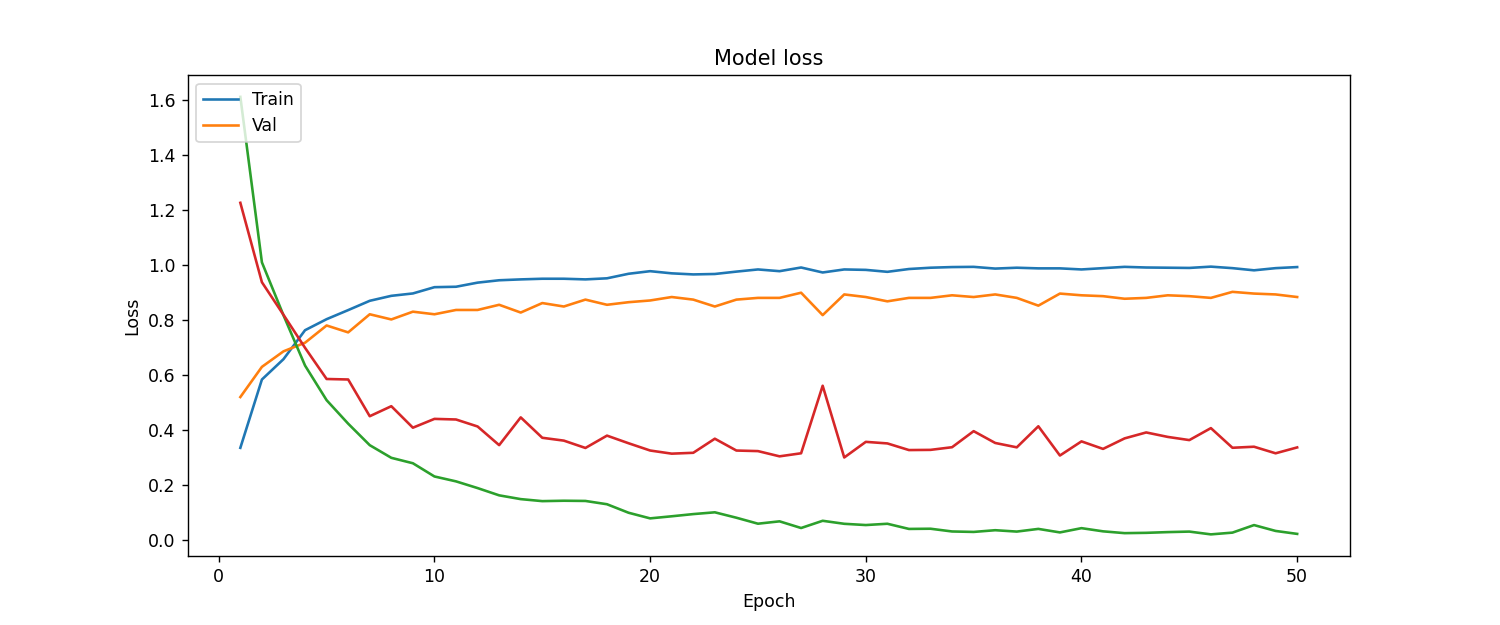

In [25]:
plt.figure()
plot_learningCurve(history, epo)

In [26]:
y_proba = model.predict_proba(X_test)*100
y_proba[0]

array([2.8622446e-03, 2.9386854e-04, 9.9994339e+01, 1.2407882e-05,
       2.2263478e-03, 4.1531953e-06, 2.5849362e-04], dtype=float32)

In [27]:
y_pred = model.predict_classes(X_test)
print(X_test.shape)
y_pred

(319, 52, 3)


array([2, 3, 4, 1, 1, 2, 3, 1, 0, 2, 2, 4, 4, 3, 2, 1, 3, 1, 0, 0, 2, 2,
       3, 6, 5, 3, 3, 1, 3, 4, 4, 4, 6, 6, 6, 4, 2, 0, 0, 0, 6, 6, 6, 4,
       3, 4, 1, 2, 0, 1, 4, 0, 2, 6, 2, 2, 6, 4, 2, 6, 4, 4, 1, 0, 0, 6,
       6, 6, 3, 0, 3, 4, 2, 4, 1, 6, 6, 1, 2, 2, 2, 4, 4, 3, 0, 6, 6, 6,
       2, 5, 1, 1, 2, 6, 3, 6, 6, 6, 1, 0, 3, 4, 1, 1, 6, 2, 4, 1, 2, 0,
       2, 4, 2, 1, 1, 4, 0, 2, 3, 1, 2, 0, 1, 4, 6, 2, 0, 0, 3, 4, 3, 6,
       2, 3, 2, 1, 4, 0, 3, 4, 0, 2, 4, 3, 3, 3, 2, 5, 3, 6, 6, 1, 4, 2,
       3, 2, 4, 0, 6, 4, 1, 5, 6, 2, 1, 3, 2, 6, 3, 2, 6, 3, 6, 4, 2, 1,
       6, 6, 1, 1, 0, 6, 1, 1, 1, 4, 5, 4, 6, 4, 1, 2, 2, 2, 3, 2, 4, 1,
       2, 1, 2, 3, 5, 4, 0, 4, 4, 3, 0, 4, 3, 1, 5, 3, 0, 2, 2, 3, 3, 3,
       4, 4, 3, 2, 2, 6, 2, 4, 3, 1, 0, 2, 4, 4, 4, 3, 1, 4, 6, 4, 0, 6,
       3, 3, 2, 1, 3, 0, 1, 2, 6, 6, 4, 3, 2, 3, 0, 3, 0, 0, 5, 4, 2, 3,
       3, 6, 5, 2, 2, 6, 6, 4, 3, 3, 6, 0, 1, 4, 1, 4, 2, 1, 3, 5, 5, 2,
       3, 2, 1, 6, 3, 1, 0, 5, 3, 1, 3, 1, 2, 1, 2,

(319,) (319,)
319/319 [==============================] - 0s 219us/sample - loss: 0.3372 - accuracy: 0.8840
test loss, test acc: [0.3372086637819822, 0.8840125]


<IPython.core.display.Javascript object>


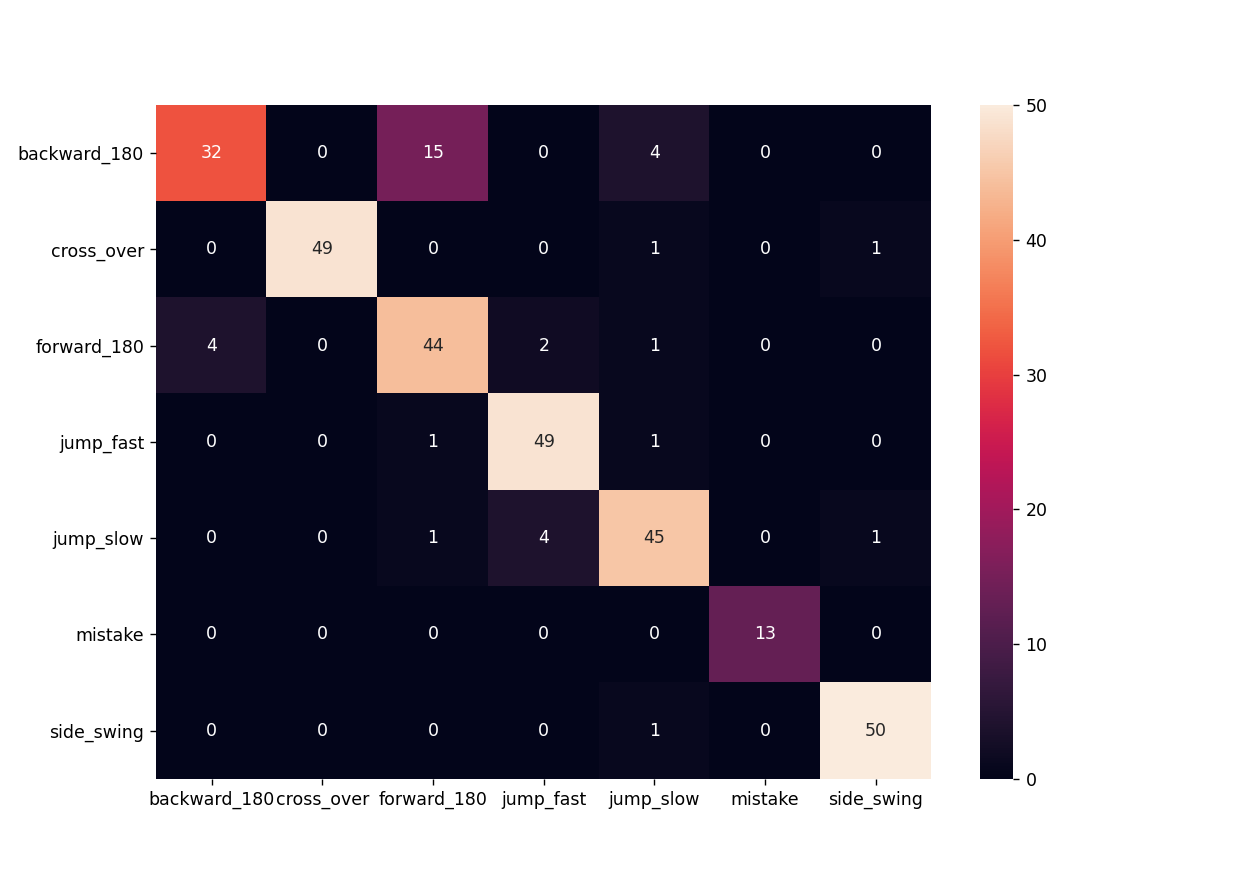

[0.3372086637819822, 0.8840125]


In [28]:
print(y_test_1.shape, y_pred.shape)
mat = confusion_matrix(y_test_1, y_pred)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
heatmap(mat, label)
print(results)

1591/1591 [==============================] - 0s 167us/sample - loss: 0.0734 - accuracy: 0.9767
test loss, test acc: [0.07343949568813514, 0.9767442]


<IPython.core.display.Javascript object>


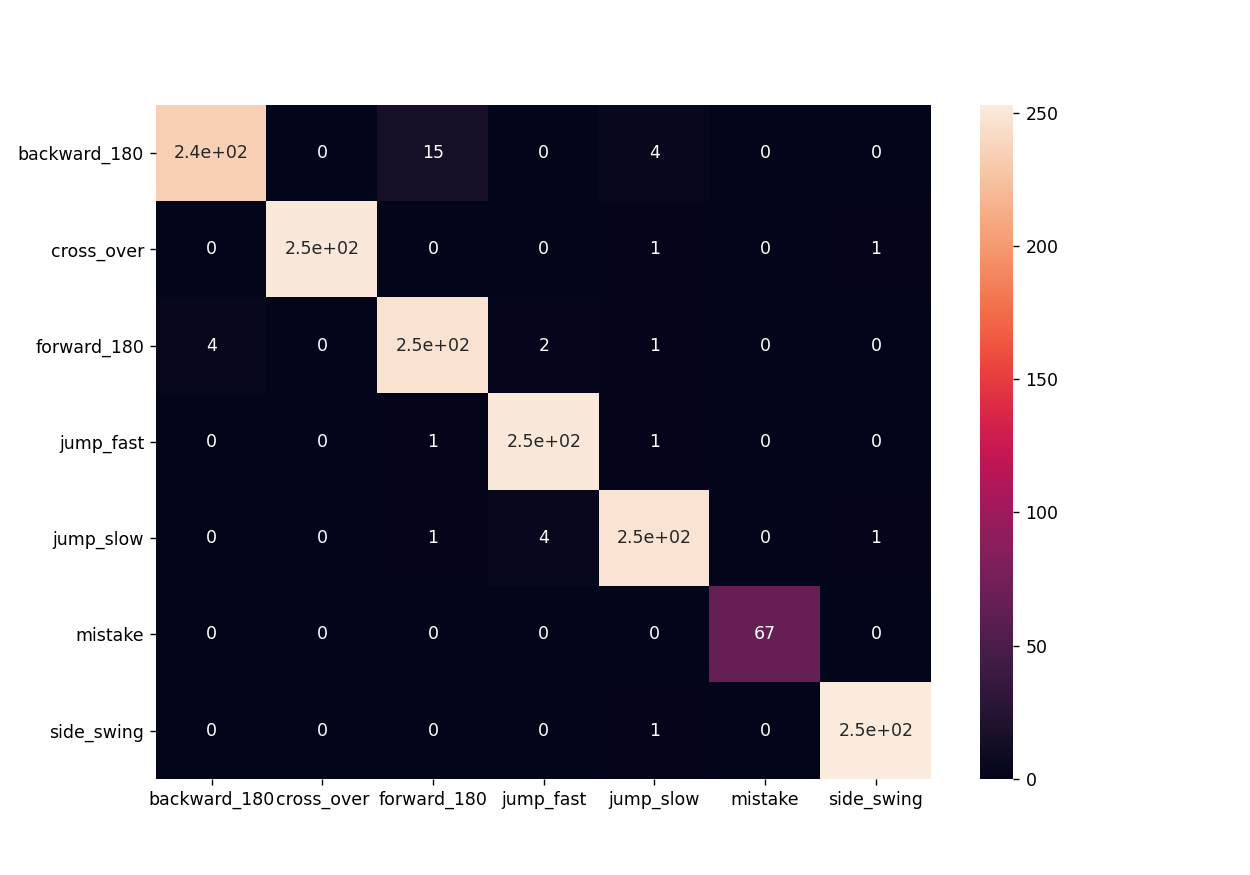

[0.07343949568813514, 0.9767442]


In [34]:
y = np.asarray(pd.get_dummies(Y), dtype = np.int8)
y_pred = model.predict_classes(X)
mat = confusion_matrix(Y, y_pred)
results = model.evaluate(X, y)
print('test loss, test acc:', results)
heatmap(mat, label)
print(results)

## save model

In [29]:
model.save('rope_skipping_simple_cnn') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rope_skipping_simple_cnn\assets


In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model("rope_skipping_simple_cnn")
tflite_model = converter.convert()
open("converted_model2.tflite", "wb").write(tflite_model)

672848